In [ ]:
import numpy as np
import os 
from itertools import combinations

from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform

In [18]:
def fasta_dict(infile):
    seqs = {}
    with open(infile, 'r') as file:
        seq_id = None
        seq_lines = []
        for line in file:
            line = line.strip()
            if line.startswith('>'):
                if seq_id is not None:
                    seqs[seq_id] = ''.join(seq_lines)
                seq_id = line[1:].split()[0] 
                seq_lines = []
            else:
                seq_lines.append(line)
        if seq_id is not None:
            seqs[seq_id] = ''.join(seq_lines)
    return seqs
def remove_gap_columns(sequences):
    seq_ids = list(sequences.keys())
    lengths = [len(sequences[seq_id]) for seq_id in seq_ids]
    max_len = max(lengths)
    
    for seq_id in seq_ids:
        seq = sequences[seq_id]
        if len(seq) < max_len:
            sequences[seq_id] = seq + '-' * (max_len - len(seq))
    
    columns_to_keep = []
    for i in range(max_len):
        if all(sequences[seq_id][i] != '-' for seq_id in seq_ids):
            columns_to_keep.append(i)
    
    cleaned_seqs = {}
    for seq_id in seq_ids:
        cleaned_seq = ''.join(sequences[seq_id][i] for i in columns_to_keep)
        cleaned_seqs[seq_id] = cleaned_seq
    return cleaned_seqs

def write_fasta(seq_dict, outfile):
    with open(outfile, 'w') as f:
        for sp, seq in seq_dict.items():
            f.write(f">{sp}\n")
            for i in range(0, len(seq), 60):  # wrap lines at 60 characters
                f.write(seq[i:i+60] + '\n')

def p_distance(seq1, seq2):
    differences = sum(c1 != c2 for c1, c2 in zip(seq1, seq2))
    return differences / len(seq1)

# 3 Cleaning up the data

In [3]:
indir = r"D:\IMSc coursework\SequenceAnalysis\SequenceAnalysis-Course\HW-3\yeast_orthologues_aligned"
allseqs = {}
for file in os.listdir(indir):
    geneseqs = fasta_dict(os.path.join(indir,file))
    cleanseq = remove_gap_columns(geneseqs)
    allseqs[file] = cleanseq
    
genes = list(allseqs.keys())
species = list(allseqs['YAL008W_aligned.fasta'].keys())
allspecies_seq = {sp: '' for sp in species}

for gene in genes:
    gene_data = allseqs[gene]
    prefix_map = {sp[:3]: sp for sp in gene_data.keys()} 
    for sp in species:
        prefix = sp[:3]
        if prefix in prefix_map:
            matched_sp = prefix_map[prefix]
            allspecies_seq[sp] += gene_data[matched_sp]
            
write_fasta(allspecies_seq, 'species_aligned.fasta')



# 3b. UPGMA


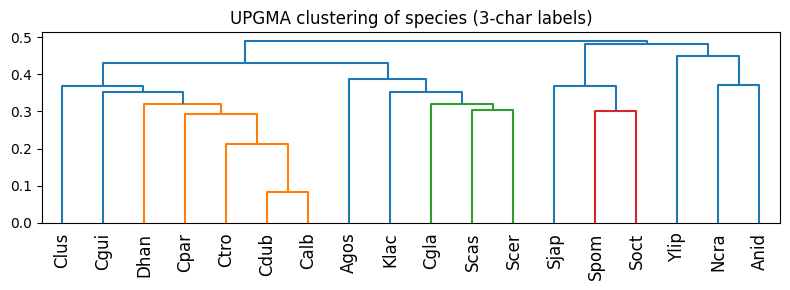

In [ ]:


species = list(allspecies_seq.keys())
n = len(species)
dist_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(i + 1, n):
        dist = p_distance(allspecies_seq[species[i]], allspecies_seq[species[j]])
        dist_matrix[i, j] = dist_matrix[j, i] = dist


condensed_dist = squareform(dist_matrix)


Z = linkage(condensed_dist, method='average')
short_labels = [sp[:4] for sp in species]

plt.figure(figsize=(8, 3))
dendrogram(Z, labels=short_labels, leaf_rotation=90)
plt.title('UPGMA clustering of species')
plt.tight_layout()
plt.show()
